# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

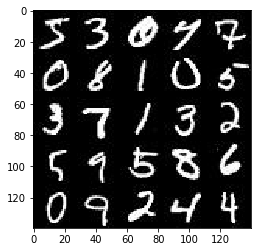

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

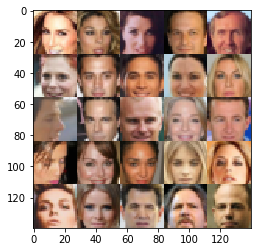

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [52]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    # Placeholder for input images
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    
    # Placeholder for noise vector
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    # Placeholder for leanring rate
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [68]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        dropout=0.5
        
        # Input layer is 28x28x3 (note: does not use batch normalization or dropout)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)     
        # output is 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        dropout2 = tf.layers.dropout(bn2, rate=dropout)
        relu2 = tf.maximum(alpha * dropout2, dropout2)     
        # output is 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        dropout3 = tf.layers.dropout(bn3, rate=dropout)
        relu3 = tf.maximum(alpha * dropout3, dropout3)        
        # output is 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        # output is 1
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [69]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        dropout=0.5
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        dropout1 = tf.layers.dropout(bn1, rate=dropout)
        relu1 = tf.maximum(alpha * dropout1, dropout1)
        # output is 2x2x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        dropout2 = tf.layers.dropout(bn2, rate=dropout)
        relu2 = tf.maximum(alpha * dropout2, dropout2)
        # output is 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        dropout3 = tf.layers.dropout(bn3, rate=dropout)
        relu3 = tf.maximum(alpha * dropout3, dropout3)
        # output is 14x14x128
                
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # output is 28x28xout_channel_dim
               
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [70]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # To help discriminator generalize better labels for real images are reduced from 1.0 to 0.9
    smooth = 0.1
    d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    
    # lables are all zero for fake images
    d_labels_fake = tf.zeros_like(d_model_fake)   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_labels_fake))
    
    # Total discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    # labels are all ones as generator is trying to fool discriminator
    g_labels_fake = tf.ones_like(d_model_fake)    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels_fake))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [71]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [72]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [73]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Image params
    _, image_width, image_height, image_channels = data_shape  
    print("image_width={}, image_height={}, image_channels={}".format(image_width, image_height, image_channels))
    
    # Get the placeholders
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Get the loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    # Get the optimization operations
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    output_stats_step_freq = 64
    output_image_step_freq = 256
    show_n_images = 25
    
    # Dictionary used to track discriminator and generator losses
    history = {}
    history["discriminator"] = []
    history["generator"] = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Scale images to range of -1 to 1 to match generator range
                batch_images *= 2.0
                               
                # Sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, 
                             feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr : learning_rate})
                
                _ = sess.run(g_train_opt, 
                             feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr : learning_rate})
                
                if steps % output_stats_step_freq == 0:
                    # Get the discriminator and generator losses
                    discriminator_train_loss = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    
                    generator_train_loss = g_loss.eval({inputs_z: batch_z})
                   
                    print("Epoch {}/{}: Discriminator Loss: {:.4f}, Generator Loss: {:.4f}".format(
                        epoch_i + 1, 
                        epoch_count, 
                        discriminator_train_loss, 
                        generator_train_loss))
                          
                    # Track discriminator and generator losses 
                    history["discriminator"].append(discriminator_train_loss)
                    history["generator"].append(generator_train_loss)
                    
                if steps % output_image_step_freq == 0:
                    show_generator_output(sess, show_n_images, inputs_z, image_channels, data_image_mode)
                    
    return history

In [74]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the loss for the discriminator and generator
    :history: Dictionary of discriminator and generator losses
    """
    event_count = range(1, len(history["discriminator"]) + 1)

    # visualize loss history
    plt.plot(event_count, history["discriminator"], 'r-')
    plt.plot(event_count, history["generator"], 'b-')
    plt.legend(['Discriminator Loss', 'Generator Loss'])
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

image_width=28, image_height=28, image_channels=1
Epoch 1/2: Discriminator Loss: 1.3094, Generator Loss: 0.5631
Epoch 1/2: Discriminator Loss: 1.0489, Generator Loss: 1.3450
Epoch 1/2: Discriminator Loss: 2.0067, Generator Loss: 0.2659
Epoch 1/2: Discriminator Loss: 1.8415, Generator Loss: 0.3035


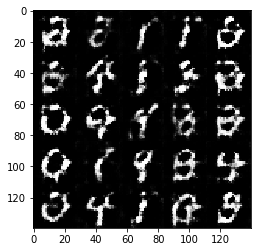

Epoch 1/2: Discriminator Loss: 1.5003, Generator Loss: 1.4496
Epoch 1/2: Discriminator Loss: 1.1275, Generator Loss: 0.9756
Epoch 1/2: Discriminator Loss: 1.4477, Generator Loss: 1.7230
Epoch 1/2: Discriminator Loss: 1.3325, Generator Loss: 1.5576


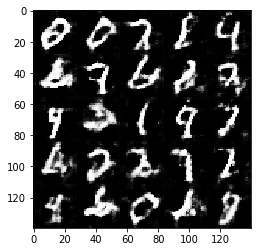

Epoch 1/2: Discriminator Loss: 1.3707, Generator Loss: 1.4316
Epoch 1/2: Discriminator Loss: 1.2383, Generator Loss: 0.6810
Epoch 1/2: Discriminator Loss: 1.1016, Generator Loss: 0.9626
Epoch 1/2: Discriminator Loss: 1.1039, Generator Loss: 1.0905


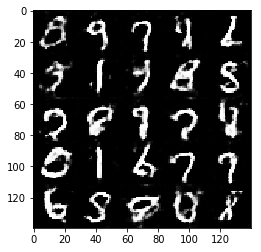

Epoch 1/2: Discriminator Loss: 1.6887, Generator Loss: 0.3264
Epoch 1/2: Discriminator Loss: 1.3202, Generator Loss: 0.5592
Epoch 1/2: Discriminator Loss: 1.2821, Generator Loss: 0.5872
Epoch 1/2: Discriminator Loss: 1.8634, Generator Loss: 1.8768


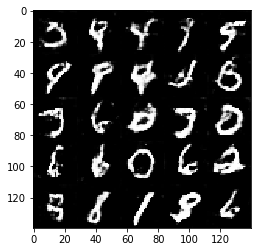

Epoch 1/2: Discriminator Loss: 1.0162, Generator Loss: 1.3925
Epoch 1/2: Discriminator Loss: 1.4968, Generator Loss: 0.4425
Epoch 1/2: Discriminator Loss: 1.2519, Generator Loss: 0.5984
Epoch 1/2: Discriminator Loss: 1.3075, Generator Loss: 0.6673


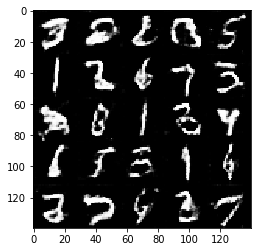

Epoch 1/2: Discriminator Loss: 2.2471, Generator Loss: 0.2270
Epoch 1/2: Discriminator Loss: 0.8931, Generator Loss: 1.7152
Epoch 1/2: Discriminator Loss: 0.9490, Generator Loss: 1.1471
Epoch 1/2: Discriminator Loss: 1.9340, Generator Loss: 0.3232


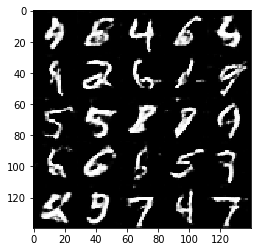

Epoch 1/2: Discriminator Loss: 1.2851, Generator Loss: 0.6211
Epoch 1/2: Discriminator Loss: 0.7331, Generator Loss: 1.5330
Epoch 1/2: Discriminator Loss: 0.9792, Generator Loss: 1.3894
Epoch 1/2: Discriminator Loss: 0.7944, Generator Loss: 1.6646


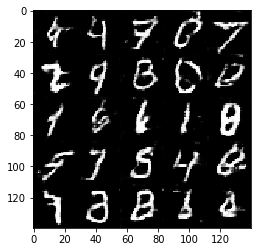

Epoch 1/2: Discriminator Loss: 1.2900, Generator Loss: 0.6794
Epoch 2/2: Discriminator Loss: 1.2818, Generator Loss: 0.5819
Epoch 2/2: Discriminator Loss: 0.7711, Generator Loss: 1.3015
Epoch 2/2: Discriminator Loss: 0.8671, Generator Loss: 2.0607


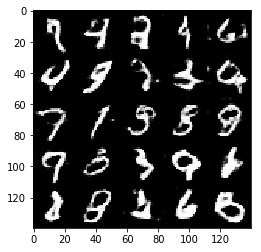

Epoch 2/2: Discriminator Loss: 1.3813, Generator Loss: 0.5911
Epoch 2/2: Discriminator Loss: 1.5190, Generator Loss: 0.5513
Epoch 2/2: Discriminator Loss: 0.9640, Generator Loss: 0.9916
Epoch 2/2: Discriminator Loss: 1.3829, Generator Loss: 0.6479


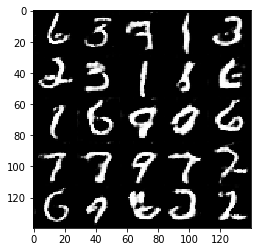

Epoch 2/2: Discriminator Loss: 0.8332, Generator Loss: 1.6826
Epoch 2/2: Discriminator Loss: 1.3470, Generator Loss: 0.5830
Epoch 2/2: Discriminator Loss: 0.5588, Generator Loss: 2.0527
Epoch 2/2: Discriminator Loss: 0.9238, Generator Loss: 0.9411


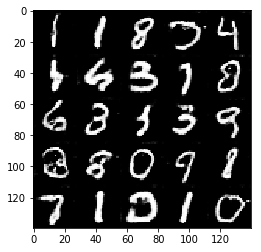

Epoch 2/2: Discriminator Loss: 1.1676, Generator Loss: 0.7724
Epoch 2/2: Discriminator Loss: 0.5862, Generator Loss: 1.9007
Epoch 2/2: Discriminator Loss: 1.8288, Generator Loss: 0.4228
Epoch 2/2: Discriminator Loss: 1.3368, Generator Loss: 0.6134


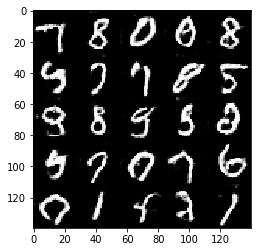

Epoch 2/2: Discriminator Loss: 0.6939, Generator Loss: 1.4321
Epoch 2/2: Discriminator Loss: 1.1501, Generator Loss: 0.8041
Epoch 2/2: Discriminator Loss: 0.9491, Generator Loss: 0.9941
Epoch 2/2: Discriminator Loss: 0.9907, Generator Loss: 0.9251


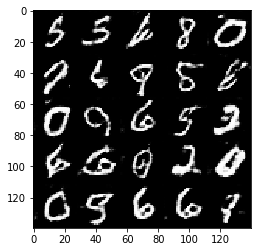

Epoch 2/2: Discriminator Loss: 0.8262, Generator Loss: 1.2193
Epoch 2/2: Discriminator Loss: 2.3805, Generator Loss: 0.2366
Epoch 2/2: Discriminator Loss: 0.6216, Generator Loss: 1.5673
Epoch 2/2: Discriminator Loss: 0.6172, Generator Loss: 1.7571


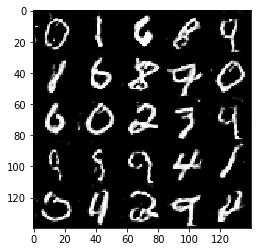

Epoch 2/2: Discriminator Loss: 0.6599, Generator Loss: 2.1584
Epoch 2/2: Discriminator Loss: 1.1104, Generator Loss: 0.7466
Epoch 2/2: Discriminator Loss: 1.4794, Generator Loss: 0.5524
Epoch 2/2: Discriminator Loss: 0.6885, Generator Loss: 1.5139


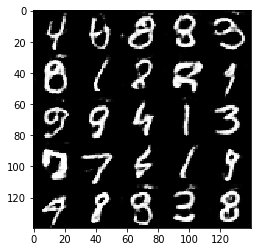

Epoch 2/2: Discriminator Loss: 0.7532, Generator Loss: 2.0999
Epoch 2/2: Discriminator Loss: 0.8170, Generator Loss: 1.8650


In [75]:
# R2: 32 --> 16
batch_size = 32

z_dim = 100

learning_rate = 0.001

# R2: 0.5 --> 0.2
beta1 = 0.2 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    training_loss = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

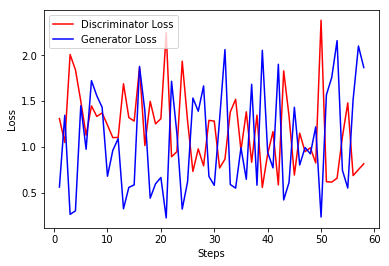

In [76]:
plot_loss(training_loss)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

image_width=28, image_height=28, image_channels=3
Epoch 1/1: Discriminator Loss: 1.2903, Generator Loss: 1.1086
Epoch 1/1: Discriminator Loss: 1.5282, Generator Loss: 0.4595
Epoch 1/1: Discriminator Loss: 1.4170, Generator Loss: 0.7895
Epoch 1/1: Discriminator Loss: 1.3103, Generator Loss: 1.1858


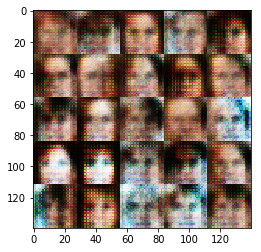

Epoch 1/1: Discriminator Loss: 1.2501, Generator Loss: 0.8058
Epoch 1/1: Discriminator Loss: 1.4243, Generator Loss: 0.7616
Epoch 1/1: Discriminator Loss: 1.3895, Generator Loss: 0.7931
Epoch 1/1: Discriminator Loss: 1.3631, Generator Loss: 1.0835


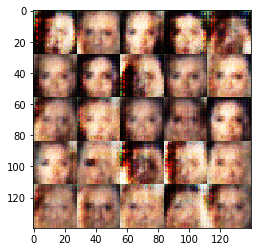

Epoch 1/1: Discriminator Loss: 1.4046, Generator Loss: 0.8232
Epoch 1/1: Discriminator Loss: 1.3170, Generator Loss: 0.7541
Epoch 1/1: Discriminator Loss: 1.4750, Generator Loss: 0.6273
Epoch 1/1: Discriminator Loss: 1.2539, Generator Loss: 1.0539


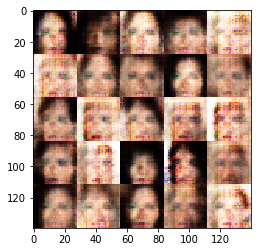

Epoch 1/1: Discriminator Loss: 1.2500, Generator Loss: 0.8345
Epoch 1/1: Discriminator Loss: 1.3595, Generator Loss: 0.7861
Epoch 1/1: Discriminator Loss: 1.3626, Generator Loss: 0.7974
Epoch 1/1: Discriminator Loss: 1.2952, Generator Loss: 0.9221


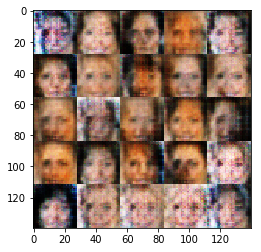

Epoch 1/1: Discriminator Loss: 1.3185, Generator Loss: 0.8043
Epoch 1/1: Discriminator Loss: 1.3469, Generator Loss: 0.7907
Epoch 1/1: Discriminator Loss: 1.3017, Generator Loss: 1.3062
Epoch 1/1: Discriminator Loss: 1.3782, Generator Loss: 1.0980


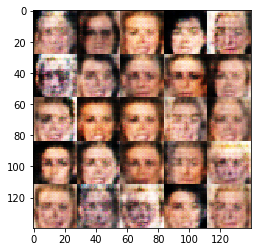

Epoch 1/1: Discriminator Loss: 1.3290, Generator Loss: 1.2357
Epoch 1/1: Discriminator Loss: 1.2158, Generator Loss: 1.1627
Epoch 1/1: Discriminator Loss: 1.3481, Generator Loss: 0.6736
Epoch 1/1: Discriminator Loss: 1.1652, Generator Loss: 0.7267


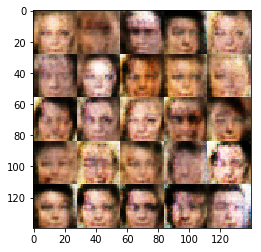

Epoch 1/1: Discriminator Loss: 1.2550, Generator Loss: 0.8370
Epoch 1/1: Discriminator Loss: 1.6206, Generator Loss: 0.4862
Epoch 1/1: Discriminator Loss: 1.3454, Generator Loss: 1.1870
Epoch 1/1: Discriminator Loss: 1.4514, Generator Loss: 0.6523


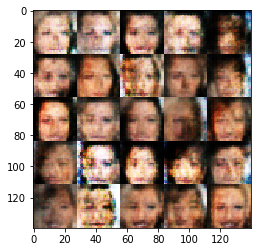

Epoch 1/1: Discriminator Loss: 1.3861, Generator Loss: 0.9633
Epoch 1/1: Discriminator Loss: 1.3074, Generator Loss: 0.8208
Epoch 1/1: Discriminator Loss: 1.2862, Generator Loss: 0.8442
Epoch 1/1: Discriminator Loss: 2.2609, Generator Loss: 0.1778


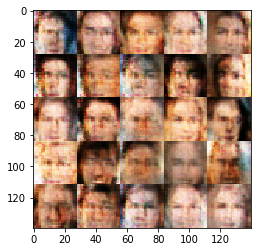

Epoch 1/1: Discriminator Loss: 1.5700, Generator Loss: 0.4405
Epoch 1/1: Discriminator Loss: 1.7253, Generator Loss: 0.3086
Epoch 1/1: Discriminator Loss: 1.3014, Generator Loss: 0.9661
Epoch 1/1: Discriminator Loss: 1.3139, Generator Loss: 0.9220


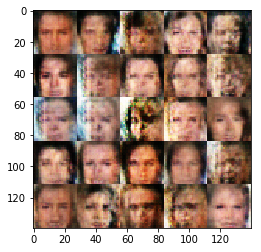

Epoch 1/1: Discriminator Loss: 1.2563, Generator Loss: 0.9587
Epoch 1/1: Discriminator Loss: 1.2442, Generator Loss: 0.8749
Epoch 1/1: Discriminator Loss: 1.3548, Generator Loss: 0.7426
Epoch 1/1: Discriminator Loss: 1.1702, Generator Loss: 1.1493


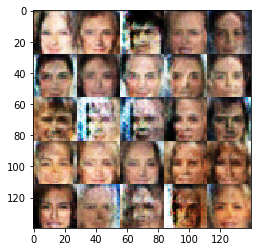

Epoch 1/1: Discriminator Loss: 1.3341, Generator Loss: 1.0328
Epoch 1/1: Discriminator Loss: 1.4051, Generator Loss: 0.7198
Epoch 1/1: Discriminator Loss: 1.3292, Generator Loss: 0.6824
Epoch 1/1: Discriminator Loss: 1.1943, Generator Loss: 0.9593


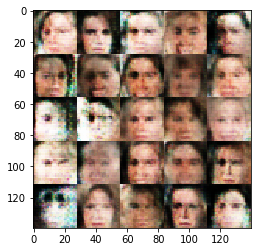

Epoch 1/1: Discriminator Loss: 1.1778, Generator Loss: 0.6693
Epoch 1/1: Discriminator Loss: 1.3364, Generator Loss: 0.7408
Epoch 1/1: Discriminator Loss: 1.2481, Generator Loss: 0.7819
Epoch 1/1: Discriminator Loss: 1.2337, Generator Loss: 0.7397


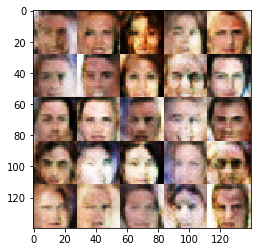

Epoch 1/1: Discriminator Loss: 1.2117, Generator Loss: 0.7977
Epoch 1/1: Discriminator Loss: 1.3293, Generator Loss: 0.8036
Epoch 1/1: Discriminator Loss: 1.3502, Generator Loss: 0.7178
Epoch 1/1: Discriminator Loss: 1.4294, Generator Loss: 0.4633


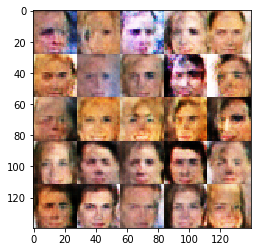

Epoch 1/1: Discriminator Loss: 1.4671, Generator Loss: 0.4813
Epoch 1/1: Discriminator Loss: 1.1350, Generator Loss: 0.6664
Epoch 1/1: Discriminator Loss: 1.3463, Generator Loss: 0.6743
Epoch 1/1: Discriminator Loss: 1.3323, Generator Loss: 1.0277


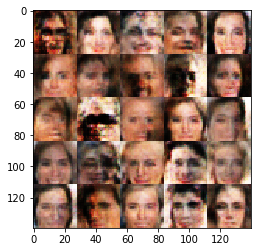

Epoch 1/1: Discriminator Loss: 1.1304, Generator Loss: 0.9635
Epoch 1/1: Discriminator Loss: 1.2920, Generator Loss: 0.7928
Epoch 1/1: Discriminator Loss: 2.2136, Generator Loss: 2.3923
Epoch 1/1: Discriminator Loss: 1.3279, Generator Loss: 1.1185


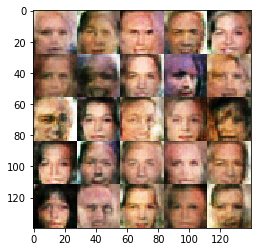

Epoch 1/1: Discriminator Loss: 1.2447, Generator Loss: 0.8509
Epoch 1/1: Discriminator Loss: 1.3420, Generator Loss: 0.9095
Epoch 1/1: Discriminator Loss: 1.3420, Generator Loss: 0.6534
Epoch 1/1: Discriminator Loss: 1.4145, Generator Loss: 0.5924


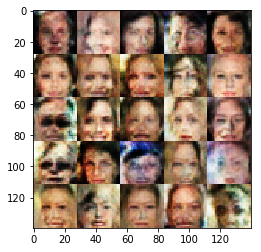

Epoch 1/1: Discriminator Loss: 1.2455, Generator Loss: 0.7913
Epoch 1/1: Discriminator Loss: 0.9818, Generator Loss: 1.0938
Epoch 1/1: Discriminator Loss: 1.2820, Generator Loss: 0.7467
Epoch 1/1: Discriminator Loss: 1.3255, Generator Loss: 0.6644


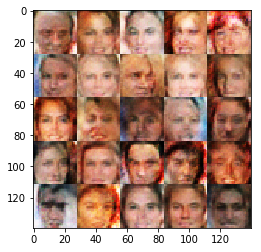

Epoch 1/1: Discriminator Loss: 1.1682, Generator Loss: 0.9093
Epoch 1/1: Discriminator Loss: 1.1992, Generator Loss: 0.8236
Epoch 1/1: Discriminator Loss: 1.2308, Generator Loss: 0.6911
Epoch 1/1: Discriminator Loss: 1.3574, Generator Loss: 0.6530


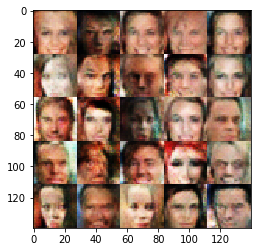

Epoch 1/1: Discriminator Loss: 1.2808, Generator Loss: 0.7332
Epoch 1/1: Discriminator Loss: 1.3501, Generator Loss: 0.5524
Epoch 1/1: Discriminator Loss: 1.1974, Generator Loss: 0.8707
Epoch 1/1: Discriminator Loss: 1.3754, Generator Loss: 0.6841


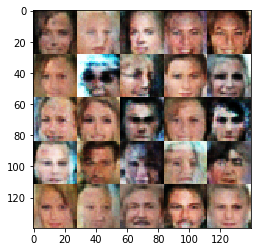

Epoch 1/1: Discriminator Loss: 1.2629, Generator Loss: 0.6977
Epoch 1/1: Discriminator Loss: 1.5933, Generator Loss: 0.3999
Epoch 1/1: Discriminator Loss: 1.7123, Generator Loss: 0.3425
Epoch 1/1: Discriminator Loss: 1.0872, Generator Loss: 0.8113


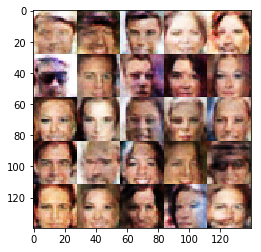

Epoch 1/1: Discriminator Loss: 1.1238, Generator Loss: 0.9049
Epoch 1/1: Discriminator Loss: 1.2615, Generator Loss: 0.7416
Epoch 1/1: Discriminator Loss: 1.1876, Generator Loss: 0.7420
Epoch 1/1: Discriminator Loss: 1.3248, Generator Loss: 0.6736


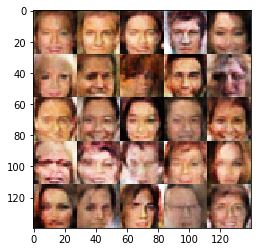

Epoch 1/1: Discriminator Loss: 1.6250, Generator Loss: 1.7462
Epoch 1/1: Discriminator Loss: 1.3033, Generator Loss: 0.7526
Epoch 1/1: Discriminator Loss: 1.2001, Generator Loss: 0.6486
Epoch 1/1: Discriminator Loss: 1.4031, Generator Loss: 0.5939


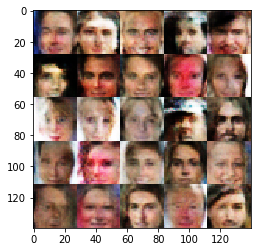

Epoch 1/1: Discriminator Loss: 1.2686, Generator Loss: 0.9959
Epoch 1/1: Discriminator Loss: 1.2331, Generator Loss: 0.8641
Epoch 1/1: Discriminator Loss: 1.1492, Generator Loss: 0.8618
Epoch 1/1: Discriminator Loss: 1.2332, Generator Loss: 0.7032


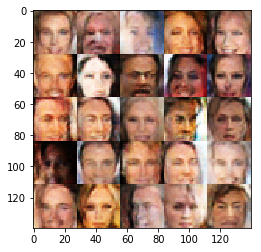

Epoch 1/1: Discriminator Loss: 1.1749, Generator Loss: 0.7599
Epoch 1/1: Discriminator Loss: 1.6535, Generator Loss: 0.3394
Epoch 1/1: Discriminator Loss: 1.2617, Generator Loss: 1.0936
Epoch 1/1: Discriminator Loss: 1.2039, Generator Loss: 0.7175


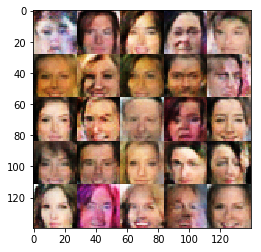

Epoch 1/1: Discriminator Loss: 1.3207, Generator Loss: 0.6322
Epoch 1/1: Discriminator Loss: 1.4383, Generator Loss: 0.5132


In [77]:
# R2: 64 --> 32
batch_size = 32

z_dim = 100

# R2: 0.0005 --> 0.001
learning_rate = 0.001

# R2: 0.5 --> 0.2
beta1 = 0.2 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    training_loss = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

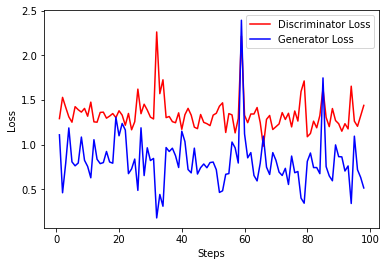

In [78]:
plot_loss(training_loss)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.